## Time-Frequency Decomposition

Now we know how to load event data, electrode data, and EEG data. We're finally ready to start looking at some electrophysiology!

Besides ERPs, the primary way neuroscientists understand EEG signals is to look for oscillations, or rhythmic fluctations in the voltage of an EEG signal. Some fluctuations occur very fast, cycling dozens of times in the span of a second, while others will see only 3 or 4 cycles a second. Breaking down EEG according to the contributions of oscillations at various frequencies is key to electrophysiological analysis. 

There are many ways to break down an EEG signal into its component frequencies and measure the contribution of each. In class, we'll switch gears to a short presentation on the Fourier Transform and time-frequency analysis ( https://github.com/pennmem/PythonBootcamp2018/blob/master/time_freq_analysis.pdf ). Don't worry if you don't get everything right away -- this is really meant to convey the big-picture ideas. 

<center>
<img src="http://neurosky.com/wp-content/uploads/2015/05/Screen-Shot-2015-05-14-at-10.41.17-AM.png" width=300>
</center>

Here's a few tips to keep in mind as you're analyzing spectral power in EEG signals: 

* We're often interested in **contrasts between conditions**, e.g. rememebered vs. not-remembered, or stimulus vs. baseline, etc. Interpreting raw power values can be difficult and should be done with care. 
* Many filters, like the Morlet wavelet, induce edge effects. Be sure to add an appropriately-sized **buffer** and remove it after filtering!
* **Line noise** and harmonics (60 Hz, 120 Hz) can contaminate analyses of high-frequency activity. Re-referencing can mitigate it somewhat, but either avoid analyzing frequencies around 60 and 120 Hz or apply a notch filter to remove residual line noise. 
* **Nyquist limit**: The maximum frequency that can be resolved is equal to the sampling rate divided by two (F_s/2). Subjects are often sampled at 500 Hz or 1000 Hz, corresponding to maximum resolved frequencies of 250 Hz or 500 Hz. In practice, try not to get too close to the limit anyway. This is typically not an issue for any recent subjects, since our maximum frequency of interest is rarely >200 Hz or so.
* **Bandwidth**: The lowest frequency that can be resolved in a timeseries, equal to 1/T, where T is the duration of the available time window. (Same as the smallest-possible frequency spacing.)
* There is a **fundamental trade-off** between time resolution and frequency resolution. With greater frequency resolution comes worse time resolution, and vice versa. So resolving frequencies within ~1 Hz of each other, like in the theta range, is possible, but you will not be able to make judgments about the timing of effects beyond ~1 second. Try to use time windows that contain at least **3 cycles** of your lowest frequency of interest. 

<center>
<img src="https://github.com/esolomon/PythonBootcamp2019/blob/master/figures/nyquist.png?raw=true" width=700>
</center>

## Implementing time-frequency analyses in Python

There are several Python toolboxes that have good implementations of various spectral decomposition methods. For the sake of the bootcamp, we're going to focus on two popular choices in the lab: MNE and PTSA (Python Time Series Analysis). 

* **MNE Python** is a suite of tools for analysis of neurophysiologic timeseries data. It's especially useful for EEG, but still has incredible functionality for ECoG/iEEG, which we're focusing on here. (https://martinos.org/mne/stable/index.html)

* **PTSA** is another Python-based timeseries toolbox, designed by former members of the CML. It doesnt' have nearly the breadth of MNE, but does feature a very fast implementation of the Morlet Wavelet Transform. (https://github.com/pennmem/ptsa_new)

Which toolbox you choose to use for your analyses is ultimately up to you. However, note that MNE is a well-documented and well-curated software suite with active professional backing, while PTSA is more of a home-grown approach to specific timeseries functionality. You may find that MNE's flexibility, and the wide variety of spectral analyses it supports, make it a better choice for most things.

### MNE Python
Let's take a look at doing some basic spectral analyses with MNE! First, we'll load up the same dataset we've been working with the past few days. 

In [1]:
#First, our import statements
from cmlreaders import CMLReader, get_data_index

#The "r1" database corresponds to all of the RAM subjects
df = get_data_index("r1")

#Specify which subject and experiment we want
sub = 'R1001P'
exp = 'FR1'

#Find out the sessions, localization, and montage for this subject
sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
mont = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['montage'])      #note that *usually* mont and loc will be 0.
loc = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['localization'])

#For first session...
reader = CMLReader(sub, exp, sessions[0], montage=mont, localization=loc)   #reader for loading CML data
evs = reader.load('task_events')
word_evs = evs[evs['type']=='WORD']
pairs = reader.load('pairs')

In [2]:
#Grab EEG for all events from the 70th electrode
eeg_cml = reader.load_eeg(events=word_evs, rel_start=0, rel_stop=1000, scheme=pairs[70:71])

/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


First, we'll need to convert our CMLReaders data into an MNE format. Fortunately, this has been made ridiculously simple:

In [3]:
import mne
eeg = eeg_cml.to_mne()

The basis of MNE is the **EpochsArray** structure. It's a Python object that nicely wraps up pertinent information about an EEG-type timeseries, including channel names, sample rates, and event information. Note how our eeg object has information about events and time, among others. It also supports more advanced functionality like filtering, re-referencing, and channel rejection, which we won't get in to right now.

**(Tip: MNE functions can often take raw numpy arrays just as well as an EpochsArray -- just be sure you've got the array dimensions right!)**

In [4]:
eeg?

Type:        EpochsArray
String form:
<EpochsArray  |   300 events (all good), 0 - 0.998 sec, baseline off, ~1.2 MB, data loaded,
 '1': 300>
Length:      300
File:        ~/anaconda3/envs/CML/lib/python3.6/site-packages/mne/epochs.py
Docstring:  
Epochs object from numpy array.

Parameters
----------
data : array, shape (n_epochs, n_channels, n_times)
    The channels' time series for each epoch. See notes for proper units of
    measure.
info : instance of Info
    Info dictionary. Consider using ``create_info`` to populate
    this structure.
events : None | array of int, shape (n_events, 3)
    The events typically returned by the read_events function.
    If some events don't match the events of interest as specified
    by event_id, they will be marked as 'IGNORED' in the drop log.
    If None (default), all event values are set to 1 and event time-samples
    are set to range(n_epochs).
tmin : float
    Start time before event. If nothing provided, defaults to 0.
event_id : int |

In [5]:
#Use this opportunity to tab-complete eeg's attributes.
eeg.info['sfreq']

500.0

In [6]:
#Let's take a look at the average power spectrum across these events (Welch's method)
from mne import time_frequency

psds, freqs = time_frequency.psd_welch(eeg, fmin=3, fmax=150)  #the output is size (events x channels x freqs)

Effective window size : 0.512 (s)


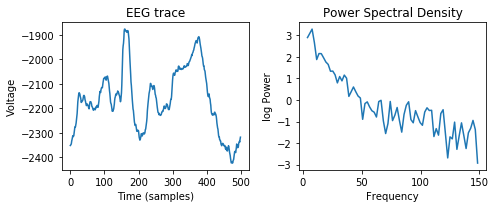

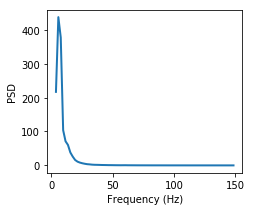

In [7]:
#Plot our results
%matplotlib inline
from pylab import *

#Plot individual trial example
figure(figsize=(7, 3)); ax=subplot(121);
plot(eeg.get_data()[10, 0, :]);
title('EEG trace'); xlabel('Time (samples)'); ylabel('Voltage')
ax=subplot(122);
plot(freqs, np.log10(psds[10, 0, :]))
title('Power Spectral Density'); xlabel('Frequency'); ylabel('log Power');
tight_layout()

figure(figsize=(3.5, 3)); ax=subplot(111)
plot(freqs, np.mean(psds[:, 0, :], 0), linewidth=2)
ylabel('PSD'); xlabel('Frequency (Hz)');

Note how the power at high frequencies is significantly smaller than at low frequencies. This is a classic relationship found in many natural signals, called the **"1/f"** phenomenon. It means that the amplitude of high-frequency signals tends to be much smaller than the amplitude of low-frequency signals. 

Unfortunately, this relationship makes it difficult to visualize changes at high frequencies, or properly assess differences between frequency bands. This is why we almost always take the log of power values before going forward with our analyses. 

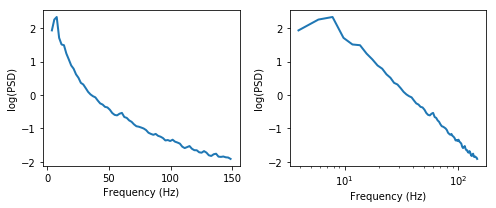

In [273]:
log_psds = np.log10(psds)

figure(figsize=(7, 3)); ax=subplot(121)
plot(freqs, np.mean(log_psds[:, 0, :], 0), linewidth=2)
ylabel('log(PSD)'); xlabel('Frequency (Hz)');

#Plot on a log axis to better see low frequencies
ax=subplot(122)
semilogx(freqs, np.mean(log_psds[:, 0, :], 0), linewidth=2)
ylabel('log(PSD)'); xlabel('Frequency (Hz)');

tight_layout()  #This cleans up our plots a bit

That's much better! We can definitely see more things going on at all points throughout our frequency range. Note that there are several other ways to normalize power values -- some of which we will discuss -- than can also be applied after an initial log transform.

**Exercise: Analyze 3 seconds of the power sectrum of the first channel. What do you notice?**

Effective window size : 0.512 (s)


/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


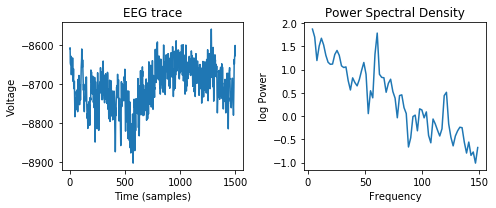

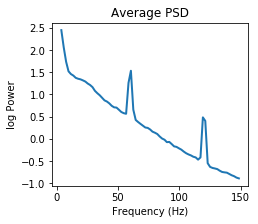

In [431]:
eeg_cml = reader.load_eeg(events=word_evs, rel_start=0, rel_stop=3000, scheme=pairs[0:1])
eeg = eeg_cml.to_mne()

#Get power spectral densities
psds, freqs = time_frequency.psd_welch(eeg, fmin=3, fmax=150)  #the output is size (events x channels x freqs)

#Plot individual trial example
figure(figsize=(7, 3)); ax=subplot(121);
plot(eeg.get_data()[0, 0, :]);
title('EEG trace'); xlabel('Time (samples)'); ylabel('Voltage')
ax=subplot(122);
plot(freqs, np.log10(psds[0, 0, :]))
title('Power Spectral Density'); xlabel('Frequency'); ylabel('log Power');
tight_layout()

#Plot average PSD over all trials
figure(figsize=(3.5, 3)); ax=subplot(111)
plot(freqs, np.log10(np.mean(psds[:, 0, :], 0)), linewidth=2)
title('Average PSD'); xlabel('Frequency (Hz)'); ylabel('log Power');

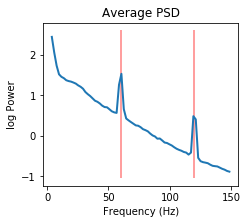

In [429]:
#Where's the line noise?
figure(figsize=(3.5, 3)); ax=subplot(111)
plot(freqs, np.log10(np.mean(psds[:, 0, :], 0)), linewidth=2)
title('Average PSD'); xlabel('Frequency (Hz)'); ylabel('log Power')
vlines([60, 120], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', alpha=0.5)

Setting up band-stop filter from 58 - 62 Hz
Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz
Effective window size : 0.512 (s)


Text(0.5,1,'Notch Filtered Data')

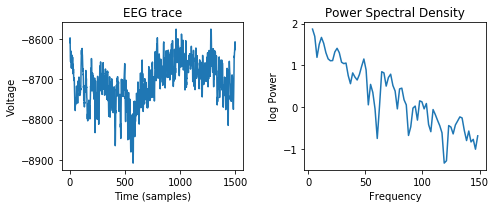

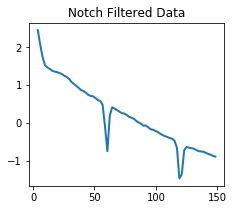

In [432]:
#Here's a potential solution -- filtering out the 60 Hz electrical line noise and its harmonic at 120 Hz

#Butterworth filtering: 60 Hz and 120 Hz
filt_data = eeg.filter(l_freq=62., h_freq=58., method='iir')
filt_data = filt_data.filter(l_freq=122., h_freq=118., method='iir')

#Get power spectral densities
psds, freqs = time_frequency.psd_welch(filt_data, fmin=3, fmax=150)  #the output is size (events x channels x freqs)

#Plot individual trial example
figure(figsize=(7, 3)); ax=subplot(121);
plot(filt_data.get_data()[0, 0, :]);
title('EEG trace'); xlabel('Time (samples)'); ylabel('Voltage')
ax=subplot(122);
plot(freqs, np.log10(psds[0, 0, :]))
title('Power Spectral Density'); xlabel('Frequency'); ylabel('log Power')
tight_layout()

#Plot average PSD
figure(figsize=(3.5, 3)); ax=subplot(111)
plot(freqs, np.log10(np.mean(psds[:, 0, :], 0)), linewidth=2)
title('Notch Filtered Data')

Effective window size : 0.512 (s)


Text(0.5,1,'Notch Filtered Data')

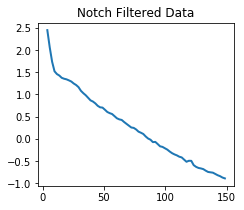

In [310]:
#spectrum_fit method
filt_data = mne.filter.notch_filter(eeg.get_data(), Fs=500., freqs=[60, 120], method='spectrum_fit')

#Get power spectral densities
psds, freqs = time_frequency.psd_array_welch(filt_data, sfreq=500., fmin=3, fmax=150)  #the output is size (events x channels x freqs)

figure(figsize=(3.5, 3)); ax=subplot(111)
plot(freqs, np.log10(np.mean(psds[:, 0, :], 0)), linewidth=2)
title('Notch Filtered Data')

**Exercise: Compare the power spectra for channel 31 between remembered and not-remembered items. Do you notice any differences?**

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


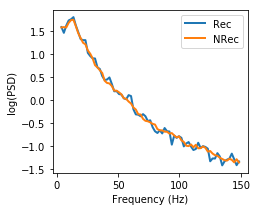

### Wavelet transform 
The wavelet transform is a powerful spectral decomposition method, since it explicitly lets us changes in the power spectrum over time. However, because this method involves convolving wavelets with our timeseries, we need to be sure to add buffers to either end of the signal (which we can clip off later). Otherwise, we'll end up eith edge effects that contaminate our results.

/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


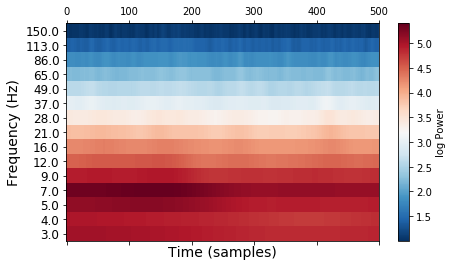

In [382]:
##### Load EEG
buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 
sr = eeg_cml.samplerate #we'll need this soon
eeg = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1000+buf, scheme=pairs[70:71]).to_mne()

#Pre-define an array of frequencies. We can log-space them since wavelets are less sensitive to differences at higher frequencies
myfreqs = np.logspace(np.log10(3), np.log10(150), num=15)

#Run TF decomposition
power = time_frequency.tfr_morlet(eeg, freqs=myfreqs, n_cycles=5, return_itc=False, average=True) #we're setting it to automatically average across trials

#Plot results
figure(figsize=(7., 4)); ax=subplot(111)
matshow(np.log10(power.data[0, :, int(buf/1000.*sr):-1*int(buf/1000.*sr)]), fignum=0, aspect='auto', cmap='RdBu_r');  #we're cutting off the buffers manually here
ax.invert_yaxis()
yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
xlabel('Time (samples)', fontsize=14); ylabel('Frequency (Hz)', fontsize=14)
cb = colorbar(); cb.set_label('log Power',)

This is nice, but we're not seeing much interesting activity because our color scale is still getting squished by the difference between low and high frequency power (despite our log transform). What if we just look at low frequencies?

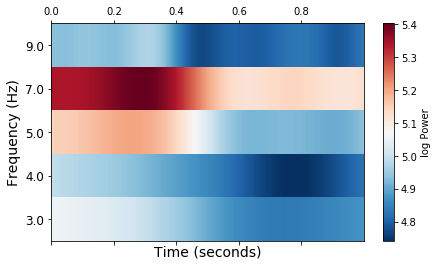

In [380]:
#Plot results
figure(figsize=(7., 4)); ax=subplot(111)
to_plot = power.data[0, 0:5, 500:-500]
matshow(np.log10(to_plot), fignum=0, aspect='auto', cmap='RdBu_r');  #we're cutting off the buffers manually here
ax.invert_yaxis()
yticks(np.arange(0, len(myfreqs[0:5])), np.round(myfreqs[0:5]), fontsize=12)
xticks(np.arange(0, to_plot.shape[1])[::100], np.arange(0, to_plot.shape[1])[::100]/500.)
xlabel('Time (seconds)', fontsize=14); ylabel('Frequency (Hz)', fontsize=14)
cb = colorbar(); cb.set_label('log Power',)

Cool! looks like there's an increase in 7 Hz power shortly after word onset which dies out after a few hundred milliseconds.

But what we *really* want to do is find the difference in power between rememebered and not-remembered trials, in order to isolate the neural activity specific to good episodic memory. Come back tomorrow to see how that's done!

**Exercise: Try a different number of wavelet cycles. What happens to the 7 Hz effect?**

**Exercise: Play around with the number of wavelet cycles, frequency, and buffer sizes. What happens as you adjust these parameters?**

## PTSA

PTSA is similar to MNE in its mission: To provide a general framework for timeseries analyses. While PTSA has much less institutional muscle behind it, it has a highly efficient implementation of the Morlet Wavelet Transform and the Butterworth Filter.

The core of PTSA is the **TimeSeriesX object**, which is an elaborated form of the numpy recarray. In particular, the TimeSeriesX object enables users to keep track of dimension metadata even after filtering or transforming the data within the object. For example, TimeSeriesX objects in PTSA nicely wrap together EEG data or power data with event information. Let's take a look:

In [279]:
#We need our data in the PTSA TimeseriesX format
buf = 1000
eeg_ptsa = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1000+buf, scheme=pairs[70:71]).to_ptsa()
eeg_ptsa

/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


<xarray.TimeSeries (event: 300, channel: 1, time: 1500)>
array([[[-2178, -2178, ..., -2280, -2283]],

       [[-2193, -2199, ..., -2177, -2181]],

       ...,

       [[-2164, -2165, ..., -2124, -2121]],

       [[-2190, -2186, ..., -2193, -2195]]], dtype=int16)
Coordinates:
  * event       (event) (numpy.record, [('index', '<i8'), ('eegfile', 'O'), ('eegoffset', '<i8'), ('exp_version', '<f8'), ('experiment', 'O'), ('intrusion', '<i8'), ('is_stim', '?'), ('item_name', 'O'), ('item_num', '<i8'), ('list', '<i8'), ('montage', '<i8'), ('msoffset', '<i8'), ('mstime', '<i8'), ('protocol', 'O'), ('recalled', '?'), ('rectime', '<i8'), ('serialpos', '<i8'), ('session', '<i8'), ('stim_list', '?'), ('stim_params', 'O'), ('subject', 'O'), ('type', 'O')]) (23, '/protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1001P_FR1_0_12Oct14_1034', 388959, 1.02, 'FR1', -999, False, 'HOUSE', 130, 1, 0, 1, 1413125314490, 'r1', False, -999, 1, 0, False, list([]), 'R1001P', 

In [280]:
#We can access the original event information as follows: 
eeg_ptsa.event.data['item_name'][0:5]

array(['HOUSE', 'HAWK', 'WAND', 'GEESE', 'STAR'], dtype=object)

In [281]:
#And we can index our EEG data by information from the events structure!
eeg_rec = eeg_ptsa[eeg_ptsa.event.data['recalled']==1]
eeg_rec.shape

(53, 1, 1500)

(Note that MNE EpochsArray also supports events metadata, but the current implementation in CMLReaders discards events information.)

In [282]:
#TimeSeriesX objects also support handy manipulations of the array structure, e.g.
eeg_ptsa_alt = eeg_ptsa.transpose('channel', 'event', 'time')
eeg_ptsa_alt.shape

(1, 300, 1500)

### Spectral Analysis

In [305]:
from ptsa.data.filters import ButterworthFilter

#Filter out line noise
freq_range = [58., 62.]
b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
eeg_filtered = b_filter.filter()

In [284]:
from ptsa.data.filters import MorletWaveletFilter

#Get spectral power
myfreqs = np.logspace(np.log10(3), np.log10(150), 15)  #let's start with 3-170 Hz, 20 frequencies
wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power')
pow_wavelet = wf.filter()  #output is freqs, events, elecs, and time
pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  #remove buffer period
pows = np.log10(pows)   #take log of powers

CPP total time wavelet loop:  0.17738032341003418


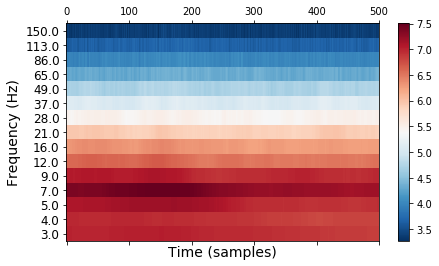

In [285]:
#Plot results
figure(figsize=(7., 4)); ax=subplot(111)
matshow(np.mean(pows[:, :, 0, :], 1), fignum=0, aspect='auto', cmap='RdBu_r');  #we're cutting off the buffers manually here
ax.invert_yaxis()
yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
xlabel('Time (samples)', fontsize=14); ylabel('Frequency (Hz)', fontsize=14)
colorbar();

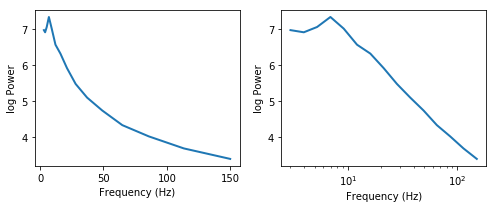

In [287]:
#look at the average spectrum, and compare to our earlier results
figure(figsize=(7, 3)); ax=subplot(121)
plot(myfreqs, np.mean(np.mean(pows[:, :, 0, :], 1), 1), linewidth=2)
ylabel('log Power'); xlabel('Frequency (Hz)')

#Plot on a log axis to better see differences at low frequencies
ax=subplot(122)
semilogx(myfreqs, np.mean(np.mean(pows[:, :, 0, :], 1), 1), linewidth=2)
ylabel('log Power'); xlabel('Frequency (Hz)')

tight_layout()

**Exercise: Compute the average time-frequency plot across all temporal cortex electrodes in subject R1111M**